Class 0: 204
Class 1: 54
Class 2: 69
Class 3: 15
Class 4: 7
Sampled class counts in one epoch:
Class 0: 296
Class 1: 290
Class 2: 265
Class 3: 251
Class 4: 293
Epoch [1/10], Loss: 1.4491, Accuracy: 40.00%, Recall: 0.39, Precision: 0.39, Specificity: 0.85, F1-Score: 0.39
Epoch [2/10], Loss: 1.1671, Accuracy: 54.41%, Recall: 0.54, Precision: 0.53, Specificity: 0.89, F1-Score: 0.52
Epoch [3/10], Loss: 1.0318, Accuracy: 58.71%, Recall: 0.60, Precision: 0.59, Specificity: 0.90, F1-Score: 0.59
Epoch [4/10], Loss: 0.8630, Accuracy: 64.95%, Recall: 0.65, Precision: 0.64, Specificity: 0.91, F1-Score: 0.64
Epoch [5/10], Loss: 0.7816, Accuracy: 69.10%, Recall: 0.70, Precision: 0.70, Specificity: 0.92, F1-Score: 0.69
Epoch [6/10], Loss: 0.7449, Accuracy: 68.96%, Recall: 0.70, Precision: 0.69, Specificity: 0.92, F1-Score: 0.69
Epoch [7/10], Loss: 0.6945, Accuracy: 71.54%, Recall: 0.72, Precision: 0.72, Specificity: 0.93, F1-Score: 0.72
Epoch [8/10], Loss: 0.6279, Accuracy: 73.33%, Recall: 0.73, Pre

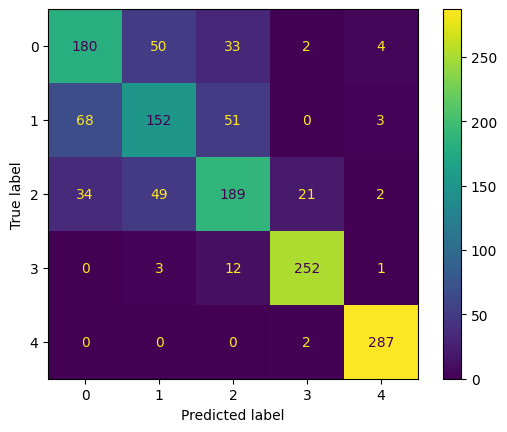

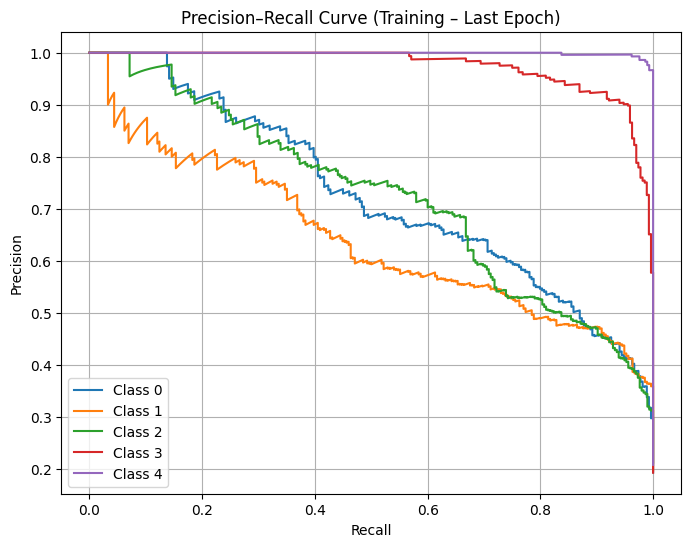

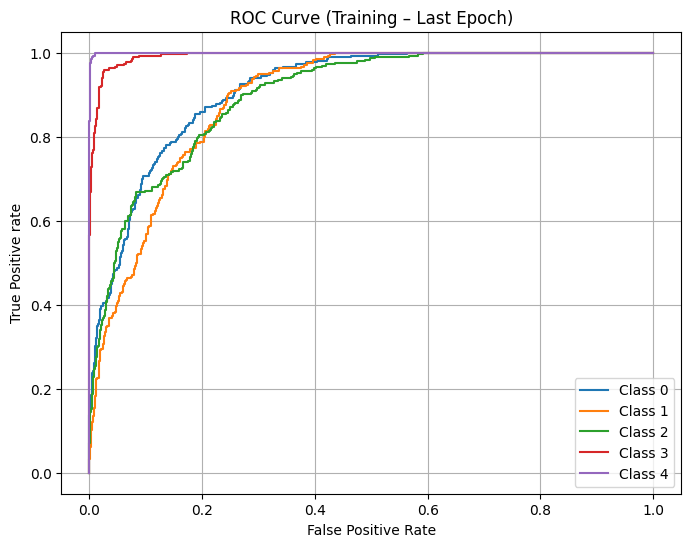

Test Accuracy: 59.60%, Recall: 0.50, Precision: 0.53, Specificity: 0.88, F1-Score: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.66      0.73       204
           1       0.27      0.39      0.32        54
           2       0.48      0.62      0.54        69
           3       0.57      0.53      0.55        15
           4       0.50      0.29      0.36         7

    accuracy                           0.60       349
   macro avg       0.53      0.50      0.50       349
weighted avg       0.65      0.60      0.61       349



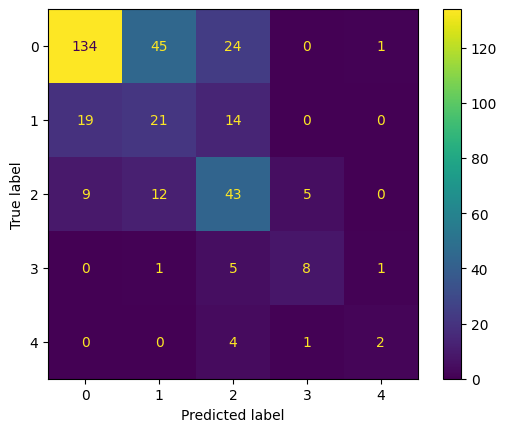

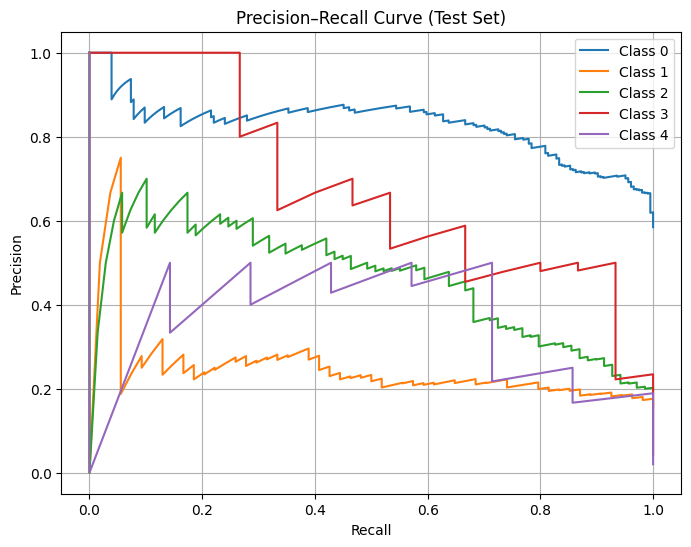

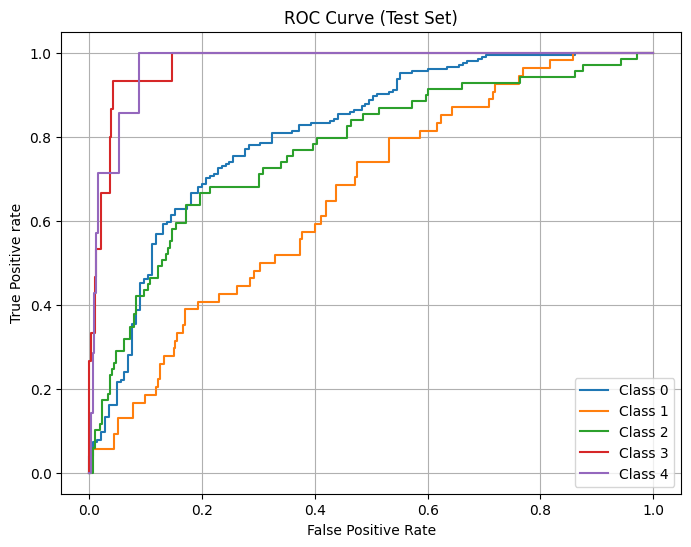

In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor_data.csv"
img_dir = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor-2/preprocess"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load MobileNetV2

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.classifier[-1] = torch.nn.Linear(
    in_features=model.classifier[-1].in_features,
    out_features=5
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.features[-3].parameters():
    param.requires_grad = True
for param in model.features[-2].parameters():
    param.requires_grad = True
for param in model.features[-1].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam([
    {"params": model.features[-3].parameters(), "lr": 1e-4},
    {"params": model.features[-2].parameters(), "lr": 1e-4},
    {"params": model.features[-1].parameters(), "lr": 1e-4},
    {"params": model.classifier[-1].parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()



Class 0: 204
Class 1: 54
Class 2: 69
Class 3: 15
Class 4: 7
Sampled class counts in one epoch:
Class 0: 279
Class 1: 285
Class 2: 273
Class 3: 284
Class 4: 274
Epoch [1/10], Loss: 1.1956, Accuracy: 48.53%, Recall: 0.49, Precision: 0.48, Specificity: 0.87, F1-Score: 0.48
Epoch [2/10], Loss: 0.7038, Accuracy: 70.82%, Recall: 0.70, Precision: 0.70, Specificity: 0.93, F1-Score: 0.70
Epoch [3/10], Loss: 0.5445, Accuracy: 78.78%, Recall: 0.80, Precision: 0.79, Specificity: 0.95, F1-Score: 0.79
Epoch [4/10], Loss: 0.4349, Accuracy: 84.52%, Recall: 0.85, Precision: 0.85, Specificity: 0.96, F1-Score: 0.85
Epoch [5/10], Loss: 0.4041, Accuracy: 83.51%, Recall: 0.84, Precision: 0.84, Specificity: 0.96, F1-Score: 0.84
Epoch [6/10], Loss: 0.2963, Accuracy: 89.53%, Recall: 0.89, Precision: 0.90, Specificity: 0.97, F1-Score: 0.89
Epoch [7/10], Loss: 0.2325, Accuracy: 91.68%, Recall: 0.92, Precision: 0.92, Specificity: 0.98, F1-Score: 0.92
Epoch [8/10], Loss: 0.1931, Accuracy: 93.19%, Recall: 0.93, Pre

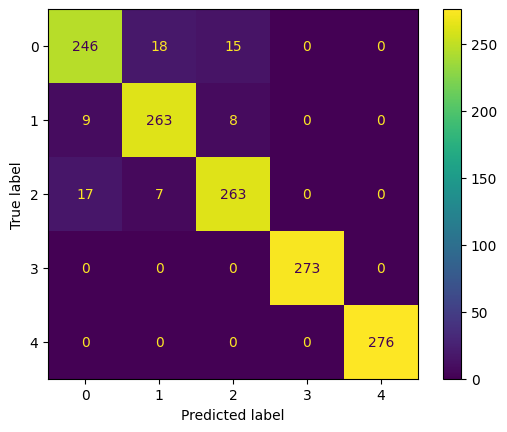

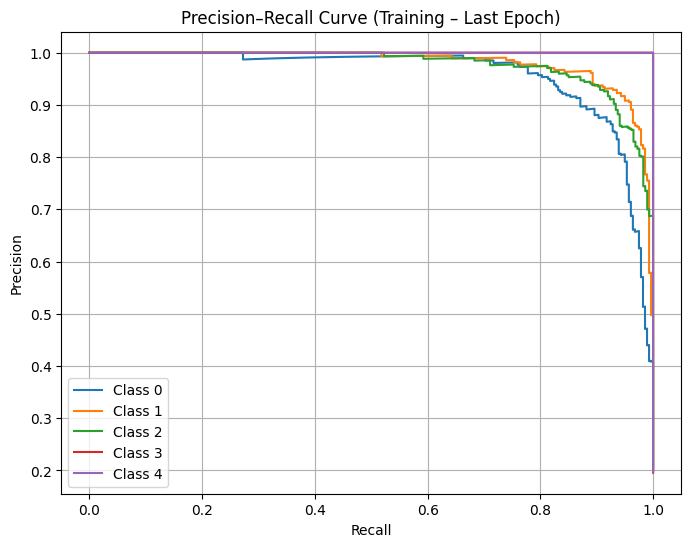

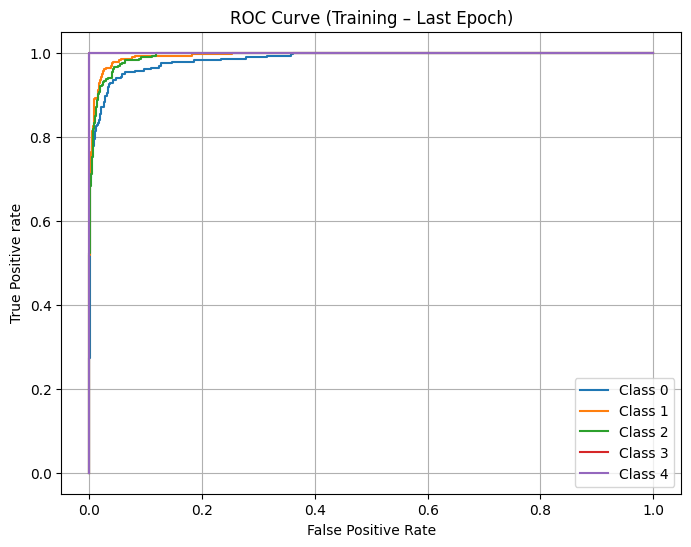

Test Accuracy: 67.62%, Recall: 0.40, Precision: 0.42, Specificity: 0.88, F1-Score: 0.40
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.90      0.82       204
           1       0.32      0.13      0.18        54
           2       0.54      0.58      0.56        69
           3       0.50      0.40      0.44        15
           4       0.00      0.00      0.00         7

    accuracy                           0.68       349
   macro avg       0.42      0.40      0.40       349
weighted avg       0.62      0.68      0.64       349



/home/matth/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/matth/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/matth/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

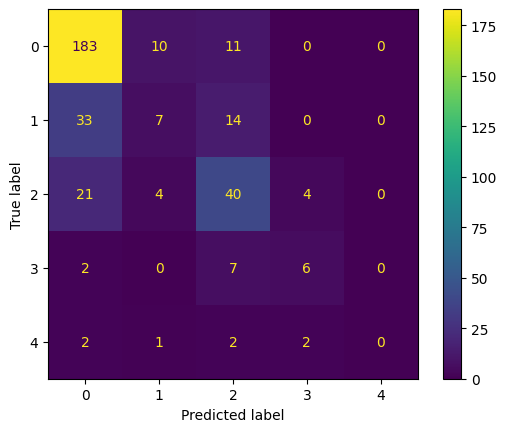

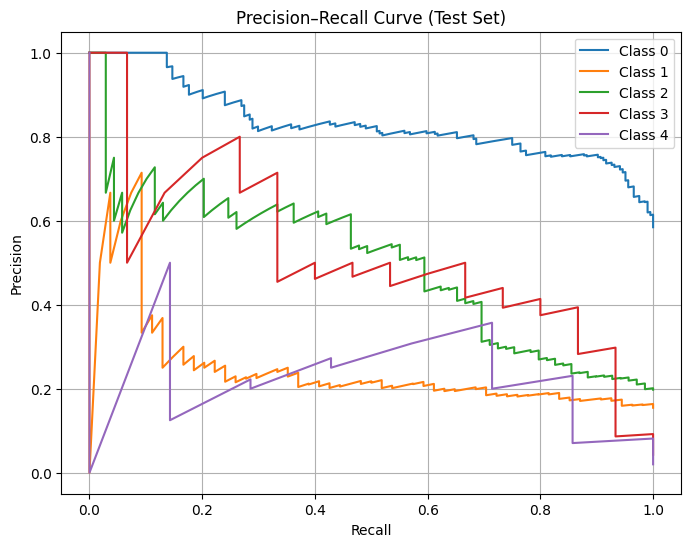

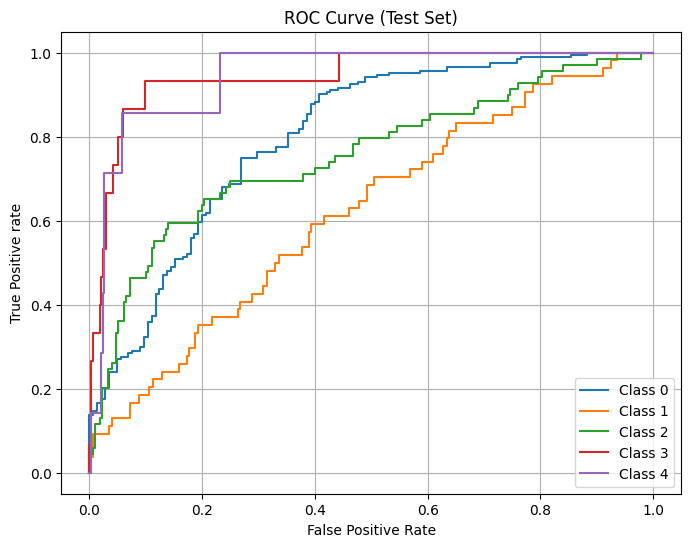

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor_data.csv"
img_dir = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor-2/preprocess"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.fc = torch.nn.Linear(
    in_features=model.fc.in_features,
    out_features=5
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {"params": model.layer3.parameters(), "lr": 1e-4},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()



Class 0: 204
Class 1: 54
Class 2: 69
Class 3: 15
Class 4: 7
Sampled class counts in one epoch:
Class 0: 272
Class 1: 288
Class 2: 285
Class 3: 270
Class 4: 280
Epoch [1/10], Loss: 1.4126, Accuracy: 39.64%, Recall: 0.39, Precision: 0.41, Specificity: 0.85, F1-Score: 0.38
Epoch [2/10], Loss: 0.8644, Accuracy: 62.51%, Recall: 0.62, Precision: 0.62, Specificity: 0.91, F1-Score: 0.62
Epoch [3/10], Loss: 0.5736, Accuracy: 76.13%, Recall: 0.76, Precision: 0.76, Specificity: 0.94, F1-Score: 0.76
Epoch [4/10], Loss: 0.4992, Accuracy: 79.64%, Recall: 0.79, Precision: 0.79, Specificity: 0.95, F1-Score: 0.79
Epoch [5/10], Loss: 0.4227, Accuracy: 82.44%, Recall: 0.82, Precision: 0.82, Specificity: 0.96, F1-Score: 0.82
Epoch [6/10], Loss: 0.3668, Accuracy: 84.95%, Recall: 0.85, Precision: 0.85, Specificity: 0.96, F1-Score: 0.85
Epoch [7/10], Loss: 0.2763, Accuracy: 89.96%, Recall: 0.90, Precision: 0.90, Specificity: 0.98, F1-Score: 0.90
Epoch [8/10], Loss: 0.2413, Accuracy: 91.83%, Recall: 0.92, Pre

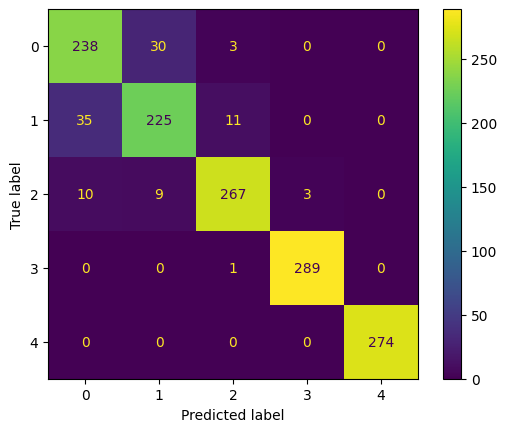

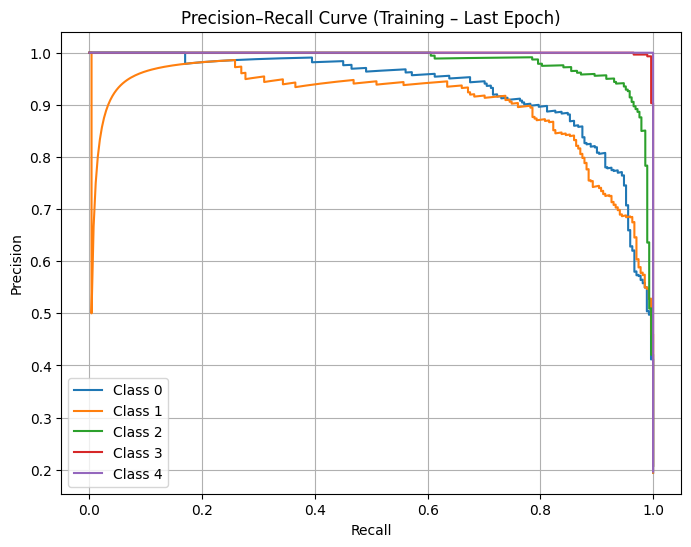

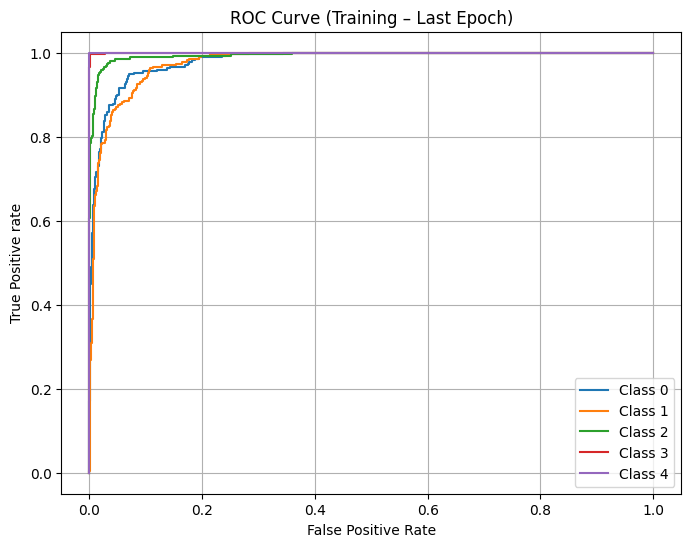

Test Accuracy: 71.35%, Recall: 0.61, Precision: 0.71, Specificity: 0.91, F1-Score: 0.64
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83       204
           1       0.39      0.37      0.38        54
           2       0.58      0.71      0.64        69
           3       0.73      0.73      0.73        15
           4       1.00      0.43      0.60         7

    accuracy                           0.71       349
   macro avg       0.71      0.61      0.64       349
weighted avg       0.72      0.71      0.71       349



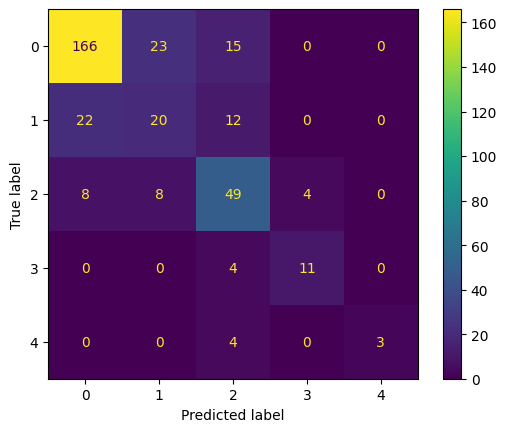

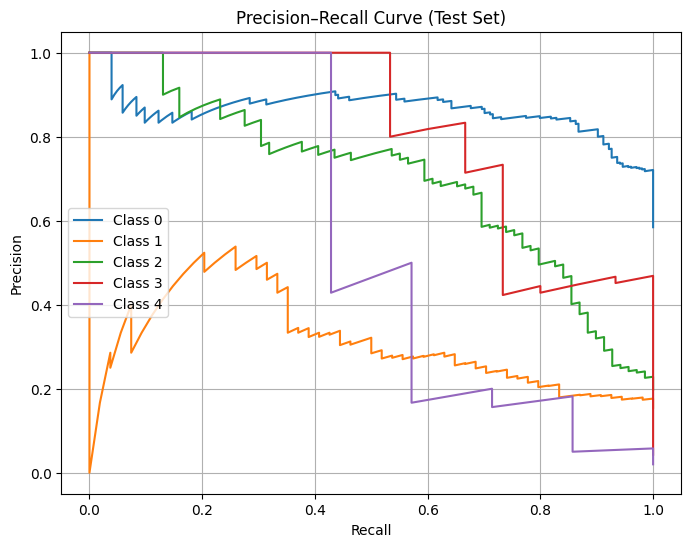

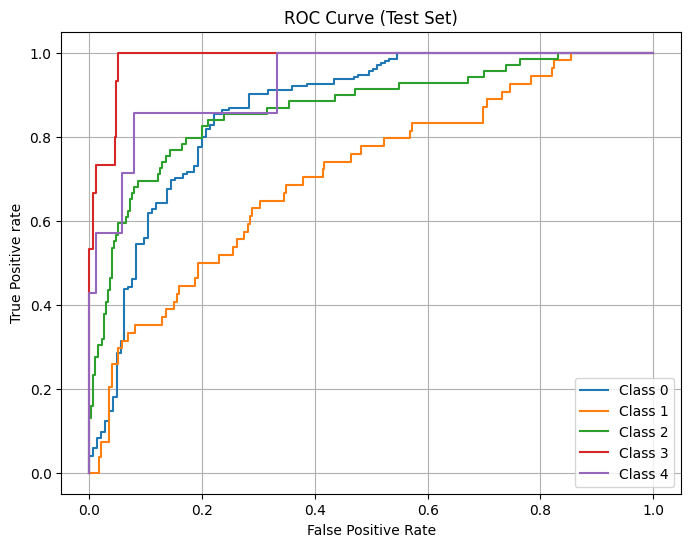

In [8]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor_data.csv"
img_dir = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor-2/preprocess"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.classifier[-1] = torch.nn.Linear(
    in_features=model.classifier[-1].in_features,
    out_features=5
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.features[-3].parameters():
    param.requires_grad = True
for param in model.features[-2].parameters():
    param.requires_grad = True
for param in model.features[-1].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {"params": model.features[-3].parameters(), "lr": 1e-4},
    {"params": model.features[-2].parameters(), "lr": 1e-4},
    {"params": model.features[-1].parameters(), "lr": 1e-4},
    {"params": model.classifier[-1].parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

